# EXAMEN DE SIMULACIÓN - PRIMER INTERCICLO
### Alejandro Enríquez 
### Ingeniería en Ciencias de la Computación
### 9no Ciclo

Objetivo: 

In [1]:
# Imports
import simpy
import random
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Instanciar Variables
NUM_MEDICOS = 6
NUM_PACIENTES = 150

TIEMPO_CONTROL = 2 # Hasta 5
TIEMPO_VACUNACION = 5 # Hasta 10
INTERVALO_LLEGADA = 15
POST_VACUNA = 1 # Hasta 3
ESPERA_INICIAL = 20

vacunados = 0
no_vacunados = 0
pacientes = 0
pacientes_atendidos = 0
bandera = 1
tiempo = 0

proceso = pd.DataFrame(columns=['pacientes','vacunados','no_vacunados'])

In [3]:
class Centro_Vacunacion(object):
    def __init__(self, environment, num_medicos, num_pacientes):
        self.env = environment
        self.num_medicos = simpy.Resource(environment, num_medicos)
        self.num_pacientes = simpy.Resource(environment, num_pacientes)
        
    def llega_paciente(self, paciente):
        print("El %s llega a las %.2f. " % (paciente, env.now))
        yield self.env.timeout(ESPERA_INICIAL)
        print("El %s entra a la fila a las %.2f. " % (paciente, env.now))
    
    def vacunar(self, paciente):
        global bandera
        global no_vacunados
        complicaciones = random.randint(1,100)
        print("El %s pasa a revisión en el padrón a las %.2f. " % (paciente, env.now))
        yield self.env.timeout(random.randint(TIEMPO_CONTROL, TIEMPO_CONTROL+3))
        if complicaciones < 95:
            print("El %s empieza la vacunación a las %.2f. " % (paciente, env.now))
            yield self.env.timeout(random.randint(TIEMPO_VACUNACION, TIEMPO_VACUNACION+5))
            print("El %s termina la vacunación a las %.2f. " % (paciente, env.now))
            bandera = 1
        else:
            print("!X!X!X! El %s no puede vacunarse y se retira a las %.2f." % (paciente, env.now))
            no_vacunados = no_vacunados+1
            bandera = 0
    
    def salida(self, paciente):
        global bandera
        global pacientes_atendidos
        if bandera == 1:
            print("El %s es llevado a la salida a las %.2f. " % (paciente, env.now))
            yield self.env.timeout(random.randint(POST_VACUNA, POST_VACUNA+2))
            print("El %s se va a las %.2f. " % (paciente, env.now))
            pacientes_atendidos = pacientes_atendidos+1
        else:
            print("El %s se va a las %.2f. " % (paciente, env.now))      


In [4]:
# Procesos
def llegada_paciente(env, nombre, vacunacion):
    yield env.process(vacunacion.llega_paciente(nombre))
    with vacunacion.num_medicos.request() as medico:
        yield medico
        yield env.process(vacunacion.vacunar(nombre))
        env.process(vacunacion.salida(nombre))
        
def ejecutar_simulacion(env, num_medicos, num_pacientes, intervalo):
    global pacientes
    global ESPERA_INICIAL
    vacunacion = Centro_Vacunacion(env, num_medicos, num_pacientes)

    for i in range(5):
        env.process(llegada_paciente(env, 'Paciente-%d' % (i+1), vacunacion))
        
    while True:
        yield env.timeout(random.randint(intervalo-3, intervalo+2))
        i+=1   
        env.process(llegada_paciente(env, 'Paciente-%d' % (i+1), vacunacion))
        pacientes = i+1

In [5]:
# Simulación
print("Iniciando Vacunación")
random.seed(77)

env = simpy.Environment()
env.process(ejecutar_simulacion(env, NUM_MEDICOS, NUM_PACIENTES, INTERVALO_LLEGADA))
env.run(until=NUM_PACIENTES*14)

Iniciando Vacunación
El Paciente-1 llega a las 0.00. 
El Paciente-2 llega a las 0.00. 
El Paciente-3 llega a las 0.00. 
El Paciente-4 llega a las 0.00. 
El Paciente-5 llega a las 0.00. 
El Paciente-6 llega a las 14.00. 
El Paciente-1 entra a la fila a las 20.00. 
El Paciente-2 entra a la fila a las 20.00. 
El Paciente-3 entra a la fila a las 20.00. 
El Paciente-4 entra a la fila a las 20.00. 
El Paciente-5 entra a la fila a las 20.00. 
El Paciente-1 pasa a revisión en el padrón a las 20.00. 
El Paciente-2 pasa a revisión en el padrón a las 20.00. 
El Paciente-3 pasa a revisión en el padrón a las 20.00. 
El Paciente-4 pasa a revisión en el padrón a las 20.00. 
El Paciente-5 pasa a revisión en el padrón a las 20.00. 
El Paciente-2 empieza la vacunación a las 22.00. 
El Paciente-5 empieza la vacunación a las 22.00. 
El Paciente-1 empieza la vacunación a las 23.00. 
El Paciente-4 empieza la vacunación a las 23.00. 
El Paciente-3 empieza la vacunación a las 25.00. 
El Paciente-5 termina la 

Pacientes en el día:  150
Pacientes Vacunados Totalmente:  139
Pacientes Incompletos:  2
Pacientes No Vacunados:  9
Tiempo promedio de vacunacion:  14.0


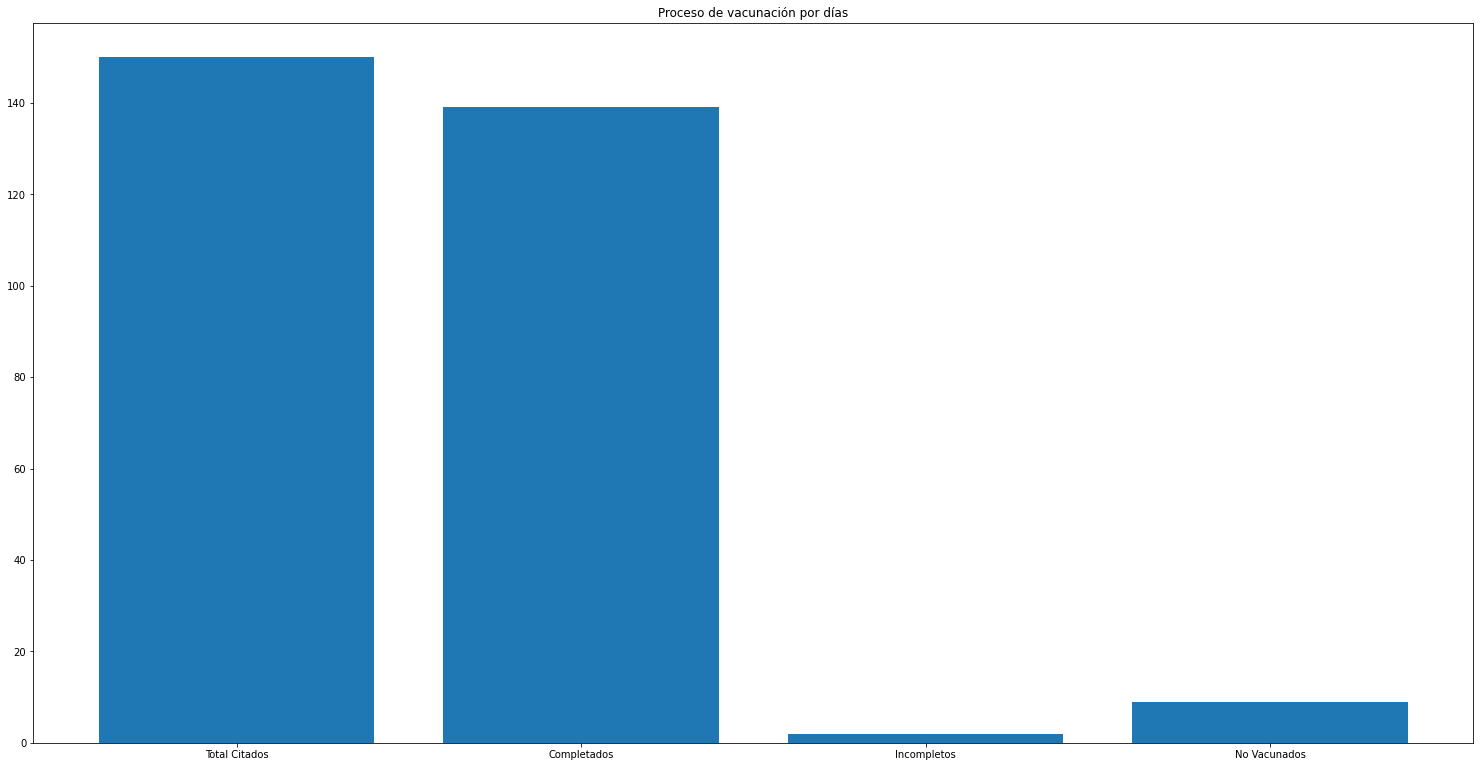

In [15]:
# Resultados y Gráficas

print("Pacientes en el día: ", pacientes)
print("Pacientes Vacunados Totalmente: ", pacientes_atendidos)
print("Pacientes Incompletos: ", pacientes-pacientes_atendidos-no_vacunados)
print("Pacientes No Vacunados: ", no_vacunados)
print("Tiempo promedio de vacunacion: ", env.now/pacientes)

labels = ['Total Citados', 'Completados', 'Incompletos', 'No Vacunados']
datos = [pacientes, pacientes_atendidos, pacientes-pacientes_atendidos-no_vacunados, no_vacunados]

fig = plt.figure(figsize=(20,10))
ax = fig.add_axes([0,0,1,1])
ax.bar(labels, datos)
plt.title('Proceso de vacunación por días')
plt.show()